In [46]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d, edge_preserving_smoothing_3d, image_smoothing_gaussian_slice_by_slice
from skimage.morphology import remove_small_objects, binary_closing, ball , dilation   # function for post-processing (size filter)
from aicssegmentation.core.utils import topology_preserving_thinning, hole_filling
from skimage.morphology import remove_small_objects     # function for post-processing (size filter)
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.seg_dot import dot_3d_wrapper, dot_2d_slice_by_slice_wrapper
from skimage.segmentation import watershed
from aicssegmentation.core.utils import peak_local_max_wrapper
from skimage.measure import label
from scipy.ndimage import distance_transform_edt
from aicssegmentation.core.vessel import filament_3d_wrapper

In [58]:
def show_seg_results(raw_img, seg_img, MID_SLICE=None):
    if MID_SLICE is None:
        MID_SLICE = np.int(0.5*raw_img.shape[0])
    fig, axs = plt.subplots(1, 2, figsize=(10,5), dpi=72, facecolor='w', edgecolor='k')

    axs[0].imshow(raw_img[MID_SLICE,:,:], cmap=plt.cm.gray)
    axs[0].set_title('Raw Image')
    axs[0].axis('off')

    axs[1].imshow(seg_img[MID_SLICE,:,:], cmap=plt.cm.gray)
    axs[1].set_title('Segmentation')
    axs[1].axis('off')

import os
os.makedirs("./test_images/jupyter_notebook_results/", exist_ok=True)

1. Sialyltransferase 1 (ST6GAL1)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(65, 624, 924)


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


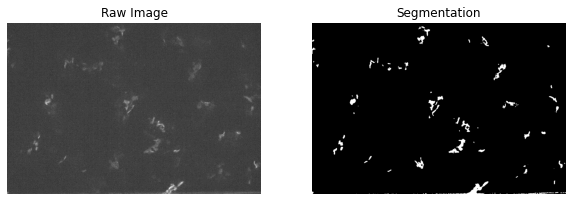

In [25]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/ST6GAL1_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> G3
struct_img0 = IMG
intensity_scaling_param = [9,19]    
gaussian_smoothing_sigma = 1      
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)    # AC 
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)  # G3 


# 核心算法 (对MO使用TT) + S3
bw, object_for_debug = MO(structure_img_smooth, global_thresh_method='tri', object_minArea=1200, return_object=True)    # MO
thin_dist_preserve=1.6
thin_dist=1
bw_thin = topology_preserving_thinning(bw>0, thin_dist_preserve, thin_dist)     # TT*
s3_param = [[1.6, 0.02]]
bw_extra = dot_3d_wrapper(structure_img_smooth, s3_param)       # S3
bw_combine = np.logical_or(bw_extra>0, bw_thin)

# 后处理 S
minArea = 10
seg = remove_small_objects(bw_combine>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/ST6GAL1_seg.tif'))
show_seg_results(IMG, out)


2. Fibrillarin (FBL)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(65, 624, 924)


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


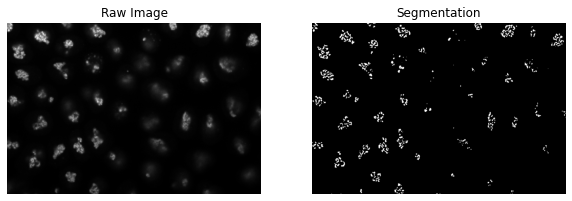

In [27]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/FBL_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> G3
struct_img0 = IMG
intensity_scaling_param = [0.5, 18] 
gaussian_smoothing_sigma = 1      
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

# 核心算法 S2
s2_param = [[1, 0.01]]
bw = dot_2d_slice_by_slice_wrapper(structure_img_smooth, s2_param)

# 后处理 S
minArea = 5
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/FBL_seg.tif'))
show_seg_results(IMG, out)


3. Nucleophosmin (NPM1)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(65, 624, 924)


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


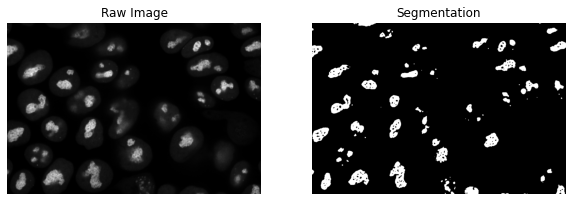

In [28]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/NPM1_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> G3
struct_img0 = IMG
intensity_scaling_param = [0.5, 15]
gaussian_smoothing_sigma = 1
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

# 核心算法 MO -> S2
bw, object_for_debug = MO(structure_img_smooth, global_thresh_method='ave', object_minArea=700, return_object=True)
s2_param_bright = [[2, 0.025]]
s2_param_dark = [[2, 0.025], [1, 0.025]]
bw_extra = dot_2d_slice_by_slice_wrapper(structure_img_smooth, s2_param_bright)
bw_dark = dot_2d_slice_by_slice_wrapper(1-structure_img_smooth, s2_param_dark)
bw_merge = np.logical_or(bw, bw_extra)
bw_merge[bw_dark>0]=0

# 后处理 S
minArea = 10
seg = remove_small_objects(bw_merge>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/NPM1_seg.tif'))
show_seg_results(IMG, out)



4. Sec61 beta (SEC61B)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(70, 624, 924)


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


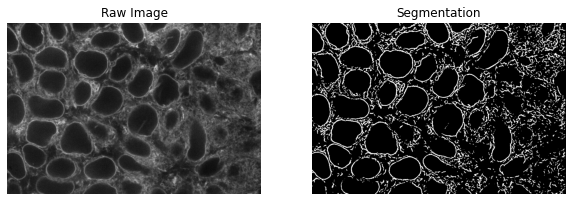

In [30]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/SEC61B_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> ES
struct_img0 = IMG
intensity_scaling_param = [2.5, 7.5]
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = edge_preserving_smoothing_3d(struct_img)

# 核心算法 F2
f2_param = [[1, 0.15]]
bw = filament_2d_wrapper(structure_img_smooth, f2_param)

# 后处理 S
minArea = 5
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/SEC61B_seg.tif'))
show_seg_results(IMG, out)



5. Tom20 (TOMM20)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(65, 624, 924)


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


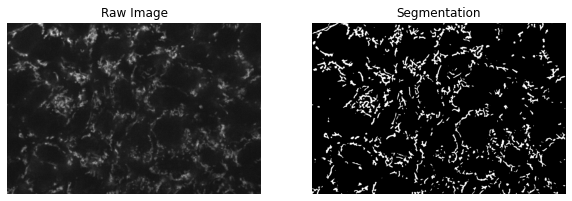

In [32]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/TOMM20_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> G3
struct_img0 = IMG
intensity_scaling_param = [3.5, 15]
gaussian_smoothing_sigma = 1
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

# 核心算法 F2
f2_param = [[1.5, 0.16]]
bw = filament_2d_wrapper(structure_img_smooth, f2_param)

# 后处理 S
minArea = 5
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/TOMM20_seg.tif'))
show_seg_results(IMG, out)



6. LAMP-1 (LAMP1)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(70, 624, 924)


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


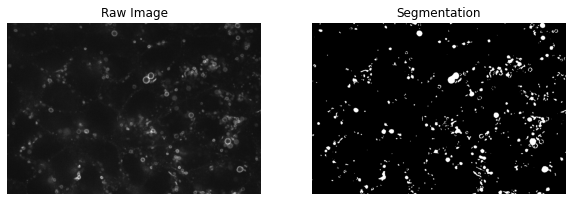

In [35]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/LAMP1_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> G2
struct_img0 = IMG
intensity_scaling_param = [3, 19]
gaussian_smoothing_sigma = 1
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = image_smoothing_gaussian_slice_by_slice(struct_img, sigma=gaussian_smoothing_sigma)

# 核心算法 S2 + F2
s2_param = [[5,0.09], [2.5,0.07], [1,0.01]]
bw_spot = dot_2d_slice_by_slice_wrapper(structure_img_smooth, s2_param)
f2_param = [[1, 0.15]]
bw_filament = filament_2d_wrapper(structure_img_smooth, f2_param)
bw = np.logical_or(bw_spot, bw_filament)

# 后处理 HF -> S
fill_2d = True
fill_max_size = 1600
minArea = 15
bw_fill = hole_filling(bw, 0, fill_max_size, fill_2d)
seg = remove_small_objects(bw_fill>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/LAMP1_seg.tif'))
show_seg_results(IMG, out)



7. Centrin-2 (CETN2)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(65, 624, 924)
intensity norm: min-max norm with upper bound 8000


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.

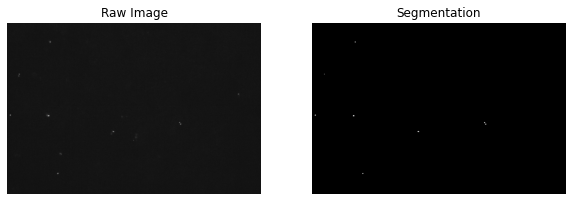

In [50]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/CETN2_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 MM -> G2
struct_img0 = IMG
intensity_scaling_param = [8000]
gaussian_smoothing_sigma = 1
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = image_smoothing_gaussian_slice_by_slice(struct_img, sigma=gaussian_smoothing_sigma)

# 核心算法 S3 → W
s3_param = [[1, 0.04]]
bw = dot_3d_wrapper(structure_img_smooth, s3_param)

minArea = 4
Mask = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False) 
Seed = dilation(peak_local_max_wrapper(struct_img,label(Mask)), selem=ball(1))
Watershed_Map = -1*distance_transform_edt(bw)
seg = watershed(Watershed_Map, label(Seed), mask=Mask, watershed_line=True)

# 后处理 S
minArea = 4 
seg = remove_small_objects(seg>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/CETN2_seg.tif'))
show_seg_results(IMG, out)



8. Desmoplakin (DSP)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(70, 624, 924)
intensity norm: min-max norm with upper bound 8000


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.

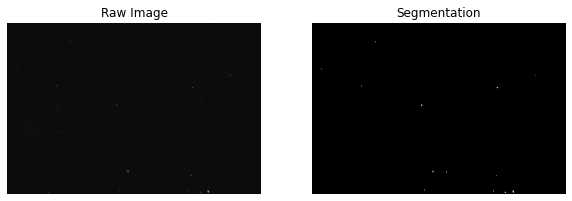

In [51]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/DSP_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 MM -> G2
struct_img0 = IMG
intensity_scaling_param = [8000]
gaussian_smoothing_sigma = 1
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = image_smoothing_gaussian_slice_by_slice(struct_img, sigma=gaussian_smoothing_sigma)

# 核心算法 S3 → W
s3_param = [[1, 0.012]]
bw = dot_3d_wrapper(structure_img_smooth, s3_param)

minArea = 4
Mask = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False) 
Seed = dilation(peak_local_max_wrapper(struct_img,label(Mask)), selem=ball(1))
Watershed_Map = -1*distance_transform_edt(bw)
seg = watershed(Watershed_Map, label(Seed), mask=Mask, watershed_line=True)

# 后处理 S
minArea = 4 
seg = remove_small_objects(seg>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/DSP_seg.tif'))
show_seg_results(IMG, out)



9. PMP34 (SLC25A17)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(65, 600, 900)
intensity norm: min-max norm with upper bound 6000


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.

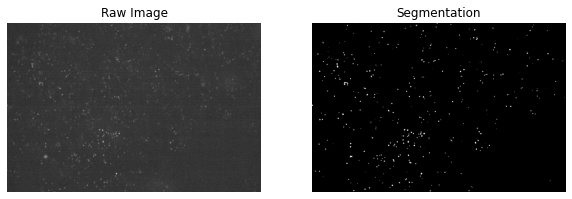

In [52]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/SLC25A17_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 MM -> G2
struct_img0 = IMG
intensity_scaling_param = [6000]
gaussian_smoothing_sigma = 1
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = image_smoothing_gaussian_slice_by_slice(struct_img, sigma=gaussian_smoothing_sigma)

# 核心算法 S3 → W
s3_param = [[1, 0.03]]
bw = dot_3d_wrapper(structure_img_smooth, s3_param)

minArea = 4
Mask = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False) 
Seed = dilation(peak_local_max_wrapper(struct_img,label(Mask)), selem=ball(1))
Watershed_Map = -1*distance_transform_edt(bw)
seg = watershed(Watershed_Map, label(Seed), mask=Mask, watershed_line=True)

# 后处理 S
minArea = 4 
seg = remove_small_objects(seg>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/SLC25A17_seg.tif'))
show_seg_results(IMG, out)



10. Connexin-43 (GJA1)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(60, 624, 924)


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


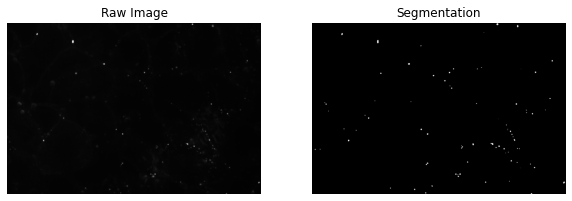

In [53]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/GJA1_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> G2
struct_img0 = IMG
intensity_scaling_param = [1, 40]
gaussian_smoothing_sigma = 1
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = image_smoothing_gaussian_slice_by_slice(struct_img, sigma=gaussian_smoothing_sigma)

# 核心算法 S3
s3_param = [[1, 0.031]]
bw = dot_3d_wrapper(structure_img_smooth, s3_param)

# 后处理 S
minArea = 5
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/GJA1_seg.tif'))
show_seg_results(IMG, out)



11. Beta catanin (CTNNB1)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(65, 624, 924)


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


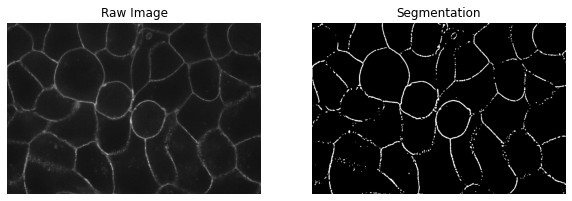

In [54]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/CTNNB1_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> G3
struct_img0 = IMG
intensity_scaling_param = [4, 27]
gaussian_smoothing_sigma = 1
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

# 核心算法 S2
s2_param = [[1.5, 0.01]]
bw = dot_2d_slice_by_slice_wrapper(structure_img_smooth, s2_param)

# 后处理 S
minArea = 5
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/CTNNB1_seg.tif'))
show_seg_results(IMG, out)



12. Tight junction protein ZO1 (TJP1)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(60, 624, 924)


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.


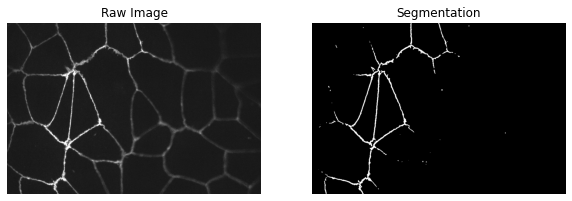

In [59]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/TJP1_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> G3
struct_img0 = IMG
intensity_scaling_param = [3, 17]
gaussian_smoothing_sigma = 1
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

# 核心算法 F3
f3_param = [[1.5, 0.2]]
bw = filament_3d_wrapper(structure_img_smooth, f3_param)

# 后处理 S
minArea = 4
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/TJP1_seg.tif'))
show_seg_results(IMG, out, 45)



13. Beta actin (ACTB)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(75, 624, 924)


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


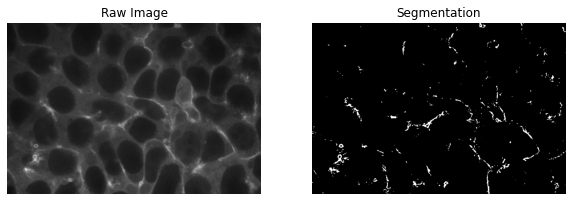

In [60]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/ACTB_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> ES
struct_img0 = IMG
intensity_scaling_param = [3, 15]
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = edge_preserving_smoothing_3d(struct_img)

# 核心算法 F3
f3_param = [[2,0.1],[1,0.04]]
bw = filament_3d_wrapper(structure_img_smooth, f3_param)

# 后处理 S
minArea = 4
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/ACTB_seg.tif'))
show_seg_results(IMG, out)



14. Non-muscle myosin IIB (MYH10)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(65, 624, 924)


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


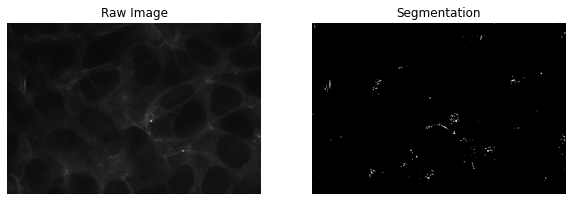

In [61]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/MYH10_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> ES
struct_img0 = IMG
intensity_scaling_param = [2.5, 17]
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = edge_preserving_smoothing_3d(struct_img)

# 核心算法 F3
f3_param = [[2,0.2],[1,0.015]]
bw = filament_3d_wrapper(structure_img_smooth, f3_param)

# 后处理 S
minArea = 4
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/MYH10_seg.tif'))
show_seg_results(IMG, out)



15. Alpha-actinin-1 (ACTN1)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(65, 624, 924)


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


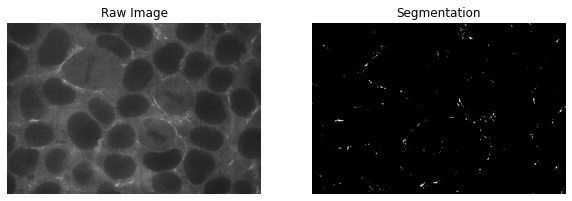

In [62]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/ACTN1_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> ES
struct_img0 = IMG
intensity_scaling_param = [3, 15]
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = edge_preserving_smoothing_3d(struct_img)

# 核心算法 F3
f3_param = [[2,0.15], [1,0.05]]
bw = filament_3d_wrapper(structure_img_smooth, f3_param)

# 后处理 S
minArea = 4
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/ACTN1_seg.tif'))
show_seg_results(IMG, out)



16. Alpha tubulin (TUBA1B)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(67, 624, 924)


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


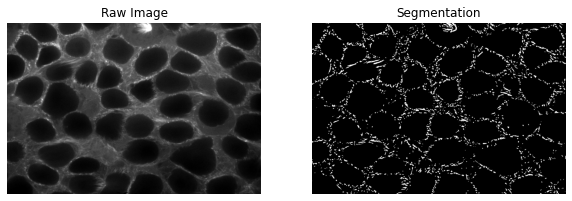

In [63]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/TUBA1B_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> ES
struct_img0 = IMG
intensity_scaling_param = [1.5, 8]
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = edge_preserving_smoothing_3d(struct_img)

# 核心算法 F3
f3_param = [[1,0.01]]
bw = filament_3d_wrapper(structure_img_smooth, f3_param)

# 后处理 S
minArea = 4
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/TUBA1B_seg.tif'))
show_seg_results(IMG, out)



17. Troponin I, show skeletal muscle (TNNI1)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


(60, 441, 555)


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


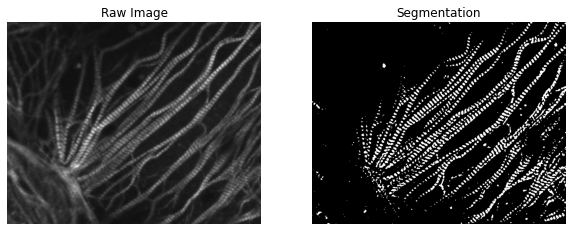

In [74]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/TNNI1_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> ES
struct_img0 = IMG
intensity_scaling_param = [2, 11]
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = edge_preserving_smoothing_3d(struct_img)

# 核心算法 F3
f3_param = [[1, 0.01]]
bw = filament_3d_wrapper(structure_img_smooth, f3_param)

# 后处理 S
minArea = 4
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/TNNI1_seg.tif'))
show_seg_results(IMG, out)



18. Titin (TTN)

In [73]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/TTN_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 AC -> ES
struct_img0 = IMG
intensity_scaling_param = [8, 15.5]
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = edge_preserving_smoothing_3d(struct_img)

# 核心算法 F3
f3_param = [[1, 0.02]]
bw = filament_3d_wrapper(structure_img_smooth, f3_param)

# 后处理 S
minArea = 4
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/TTN_seg.tif'))
show_seg_results(IMG, out)



FileNotFoundError: file:///home/projects/cellpose/test_images/structure_examples/TTN_raw.tif

19. Lamin B1 (Interphase-specific) (LMNB1)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(70, 624, 924)
intensity norm: min-max norm with upper bound 4000


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


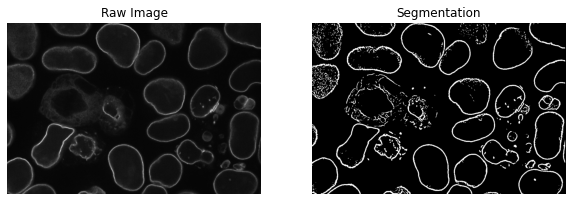

In [71]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/LMNB1_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 MM -> G3
struct_img0 = IMG
intensity_scaling_param = [4000]
gaussian_smoothing_sigma = 1
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

# 核心算法 F2
f2_param = [[0.5, 0.01]]
bw = filament_2d_wrapper(structure_img_smooth, f2_param)

# 后处理 S
minArea = 5
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/LMNB1_seg.tif'))
show_seg_results(IMG, out)



20. Lamin B1 (Mitosis-specific) (LMNB1)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


(70, 624, 924)
intensity norm: min-max norm with upper bound 4000


in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


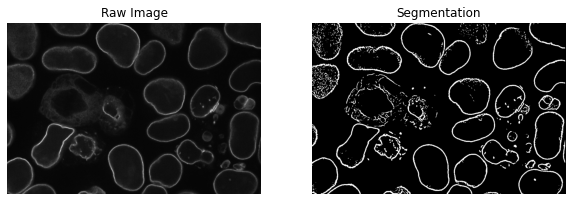

In [67]:
# 加载图像
FILE_NAME = "./test_images/structure_examples/LMNB1_raw.tif"
reader = AICSImage(FILE_NAME) 
IMG = np.squeeze(reader.data.astype(np.float32))
print(IMG.shape)

# 预处理 MM -> G3
struct_img0 = IMG
intensity_scaling_param = [4000]
gaussian_smoothing_sigma = 1
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

# 核心算法 F2
f2_param = [[0.5, 0.01]]
bw = filament_2d_wrapper(structure_img_smooth, f2_param)

# 后处理 S
minArea = 5
seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

# 保存
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
OmeTiffWriter.save(data=out, uri=str('./test_images/jupyter_notebook_results/LMNB1_seg.tif'))
show_seg_results(IMG, out)

